# Beer recommendations

Develops both content-based and collaborative filtering recommendation systems from web-scraped BeerAdvocate data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import coo_matrix
from gensim import corpora, models, similarities, matutils
from sklearn.neighbors import KDTree
import os
import pickle


lsa_model_file = 'lsa_model_full_beer.p'
lsa_mat_file = 'lsa_matrix_full_beer.p'
nmf_model_file = 'nmf_model_full_beer.p'
nmf_mat_file = 'nmf_matrix_full_beer.p'


sns.set_style('whitegrid')

%matplotlib inline

Slow version of gensim.models.doc2vec is being used


In [2]:
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

## Check topics with saison before using on larger dataset

In [3]:
saison_beer_df = pd.read_csv('saison_beer_info.csv')
saison_user_df = pd.read_csv('saison_user_info.csv')
saison_text_df = pd.read_csv('saison_text_info.csv')

In [47]:
saison_text_df.head()

,beer_ba_id,text
0,141,"<div class=""break"" style=""float:right; width:7..."
1,50570,"<div class=""break"" style=""float:right; width:7..."
2,48824,"<div class=""break"" style=""float:right; width:7..."
3,1717,"<div class=""break"" style=""float:right; width:7..."
4,36333,"<div class=""break"" style=""float:right; width:7..."


In [4]:
vectorizer = CountVectorizer(min_df=5, max_df=0.6, stop_words = 'english')
count_mat = vectorizer.fit_transform(saison_text_df.text)

In [5]:
pd.DataFrame(count_mat.toarray(),  columns=vectorizer.get_feature_names()).head(10)

,00,000,001,002,003,004,005,006,007,008,...,zesty,zinfandel,zing,zingy,zip,zippy,zone,zoo,zwanze,øl
0,1,0,0,0,0,0,0,0,0,1,...,1,0,2,1,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,2,0,0,1,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,5,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,1,1,0,...,7,0,0,0,0,1,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,11,0,0,0,1,2,0,0,0,0
6,2,1,0,0,0,0,0,0,0,1,...,6,0,0,0,1,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,0,0


### Latent Semantic Analysis

In [6]:
lsa = TruncatedSVD(50)
reduced_mat = lsa.fit_transform(count_mat)

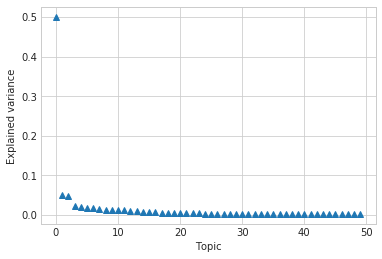

In [7]:
fig, ax = plt.subplots()
ax.plot(lsa.explained_variance_ratio_,'^')
ax.set_ylabel("Explained variance")
ax.set_xlabel("Topic");

In [8]:
terms = np.array(vectorizer.get_feature_names())

In [9]:
for i in range(5):
    print("topic {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))

topic 0
['hops' 'pepper' 'sour' 'spicy' 'belgian' 'earthy' 'floral' 'funky'
 'slight' 'sweetness' 'poured' 'brett' 'bitterness' 'apple' 'refreshing'
 'finger' 'spices' 'character' 'hop' 'mild' 'lots' 'herbal' 'touch' 'tulip'
 'big' 'pale' 'drink' 'straw' 'palate' 'wheat' 'dark' 'honey' 'retention'
 'bitter' 'brew']
topic 1
['brett' 'sour' 'oak' 'wine' 'dark' 'peach' 'tartness' 'funky' 'barrel'
 'brown' 'peaches' 'sourness' 'apple' 'red' 'grape' 'wild' 'grapes'
 'cherry' 'barnyard' 'batch' 'acidic' 'acidity' 'fantome' 'vinous'
 'chocolate' '20134' 'wood' 'green' 'lactic' 'vinegar' 'musty' 'fruits'
 'jolly' 'amber' 'apples']
topic 2
['dark' 'brown' 'chocolate' 'black' 'roasted' 'caramel' 'tan' 'fantome'
 'interesting' 'belgian' 'coffee' 'spices' 'malts' 'cocoa' 'amber' 'roast'
 'red' 'deep' 'sugar' 'roasty' 'cherry' 'malty' 'unique' 'stout' '20113'
 'creamy' 'fruits' 'spicy' 'cherries' 'strong' '20123' 'darker' 'burnt'
 'plum' 'reddish']
topic 3
['green' 'sour' 'fantome' 'honey' 'apple' 

First three topics look like they could be useful. Topic 0 looks like a typical saison, and Topic 1 looks like a barrel-aged/fruit saison. Topic 2 is especially interesting, because it probably refers to a relatively rare substyle of saison (dark saison).

### Latent Dirichlet Allocation

In [50]:
count_mat_T = count_mat.transpose()
corpus = matutils.Sparse2Corpus(count_mat_T)

In [51]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [52]:
lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10)

In [53]:
lda.print_topics(num_words=15)

[(0,
  '0.018*"dark" + 0.010*"brown" + 0.007*"black" + 0.006*"belgian" + 0.006*"caramel" + 0.006*"chocolate" + 0.005*"spicy" + 0.005*"malts" + 0.004*"interesting" + 0.004*"roasted" + 0.004*"amber" + 0.004*"earthy" + 0.004*"pepper" + 0.004*"hops" + 0.004*"sour"'),
 (1,
  '0.010*"brett" + 0.010*"sour" + 0.009*"wine" + 0.008*"oak" + 0.006*"tartness" + 0.006*"funky" + 0.004*"peach" + 0.004*"floral" + 0.004*"barrel" + 0.004*"earthy" + 0.004*"mild" + 0.004*"slight" + 0.004*"character" + 0.004*"bright" + 0.003*"apple"'),
 (2,
  '0.008*"belgian" + 0.008*"hops" + 0.007*"pepper" + 0.007*"spicy" + 0.004*"bitterness" + 0.004*"banana" + 0.004*"wheat" + 0.004*"pale" + 0.004*"sweetness" + 0.004*"refreshing" + 0.004*"clove" + 0.004*"slight" + 0.004*"spices" + 0.004*"finger" + 0.004*"yeasty"'),
 (3,
  '0.017*"brett" + 0.007*"hops" + 0.006*"funky" + 0.005*"sour" + 0.005*"cucumber" + 0.004*"floral" + 0.004*"grapefruit" + 0.004*"bitterness" + 0.004*"pumpkin" + 0.004*"pepper" + 0.004*"poured" + 0.004*"refr

Took a lot of CPU clock time to run (cost me $0.50 on AWS!) and didn't really produce better results than LSA.

### Create similarity matrix for saison terms from LSA

In [42]:
from sklearn.preprocessing import Normalizer

In [43]:
reduced_mat_norm = Normalizer(copy=False).fit_transform(reduced_mat)

In [44]:

sim_mat = np.dot(reduced_mat_norm, reduced_mat_norm.T)

In [45]:
term_similarity_df = pd.DataFrame(sim_mat, columns=saison_text_df.beer_ba_id, index=saison_text_df.beer_ba_id)

In [97]:
indices = np.argsort(-np.dot(reduced_mat_norm[4, :], reduced_mat_norm.T))[0:6]

In [101]:
dists_mat = cosine_similarity(reduced_mat, reduced_mat)

In [102]:
sim_mat[:5, :5]

array([[ 1.        ,  0.93867727,  0.90740253,  0.96984017,  0.70801262],
       [ 0.93867727,  1.        ,  0.8779297 ,  0.94712116,  0.71399471],
       [ 0.90740253,  0.8779297 ,  1.        ,  0.89733446,  0.70752129],
       [ 0.96984017,  0.94712116,  0.89733446,  1.        ,  0.73086819],
       [ 0.70801262,  0.71399471,  0.70752129,  0.73086819,  1.        ]])

In [103]:
dists_mat[:5, :5]

array([[ 1.        ,  0.93867727,  0.90740253,  0.96984017,  0.70801262],
       [ 0.93867727,  1.        ,  0.8779297 ,  0.94712116,  0.71399471],
       [ 0.90740253,  0.8779297 ,  1.        ,  0.89733446,  0.70752129],
       [ 0.96984017,  0.94712116,  0.89733446,  1.        ,  0.73086819],
       [ 0.70801262,  0.71399471,  0.70752129,  0.73086819,  1.        ]])

In [105]:
np.argsort(-dists_mat[4, :])[0:6]

array([  4, 195,  14, 118,  50, 186])

In [98]:
saison_beer_df.iloc[indices]

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants,topic_0,topic_1,topic_2
4,8.5,4.29,Saison,36333,Brett,423,873,10.02,3239,768,129,673,341.267186,84.343018,-106.463368
195,8.5,3.90,Regalia,117973,Perennial Artisan Ales,25888,31,8.72,220,28,129,8,47.288923,16.653431,-14.121573
14,8.0,4.29,Seizoen Bretta,69702,Logsdon Farmhouse Ales,25710,263,7.46,1498,263,129,190,375.604726,132.385002,-110.650645
118,6.5,3.90,Bretticent,119775,Wicked Weed Brewing,30581,100,8.97,443,56,129,13,84.864735,19.080761,-27.714964
50,6.0,4.10,Grassroots Arctic Saison,96755,Grassroots Brewing,23205,137,8.29,795,109,129,28,228.228648,78.135379,-79.970607
186,8.0,4.12,Allagash Century Ale Brett Saison,146790,Allagash Brewing Company,4,35,7.04,233,50,129,12,83.706468,22.446860,-29.943193


In [13]:
saison_beer_df.head()

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants,topic_0,topic_1,topic_2
0,7.7,4.17,Hennepin (Farmhouse Saison),141,Brewery Ommegang,42,"1,054",10.79%,6006,2176,129,360,212.016880,-39.530990,-19.251433
1,8.5,4.15,Tank 7 Farmhouse Ale,50570,Boulevard Brewing Co,423,"1,634",10.36%,5154,1049,129,333,248.543979,-57.431339,-23.762868
2,6.5,4.10,Sofie,48824,Goose Island Beer Co,1146,"1,164",10%,4479,1098,129,249,217.149246,11.935216,-39.347128
3,6.5,4.18,Saison Dupont,1717,Brasserie Dupont sprl,637,627,10.53%,4182,1617,129,286,233.161398,-47.930566,-25.817903
4,8.5,4.29,Saison,36333,Brett,423,873,10.02%,3239,768,129,673,341.267186,84.343018,-106.463368


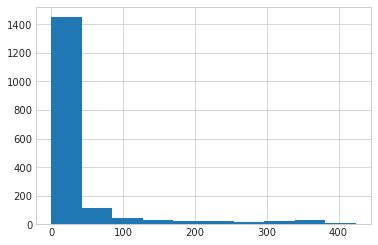

In [17]:
saison_beer_df.topic_0.hist()

In [18]:
saison_beer_df['perc_dev'] = saison_beer_df.perc_dev.map(lambda x: float(re.sub('%', '', x)))

In [19]:
saison_beer_df['wants'] = saison_beer_df.wants.map(lambda x: int(re.sub(',', '', x)))

In [20]:
saison_beer_df['gots'] = saison_beer_df.gots.map(lambda x: int(re.sub(',', '', x)))

In [21]:
saison_beer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 15 columns):
abv              1759 non-null float64
avg_score        1759 non-null float64
beer             1759 non-null object
beer_ba_id       1759 non-null int64
brewery          1759 non-null object
brewery_ba_id    1759 non-null int64
gots             1759 non-null int64
perc_dev         1759 non-null float64
ratings          1759 non-null int64
reviews          1759 non-null int64
style_ba_id      1759 non-null int64
wants            1759 non-null int64
topic_0          1759 non-null float64
topic_1          1759 non-null float64
topic_2          1759 non-null float64
dtypes: float64(6), int64(7), object(2)
memory usage: 206.2+ KB


In [22]:
saison_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205264 entries, 0 to 205263
Data columns (total 7 columns):
beer_ba_id    205264 non-null int64
feel          112807 non-null float64
look          112807 non-null float64
score         205264 non-null float64
smell         112807 non-null float64
taste         112807 non-null float64
user_id       205210 non-null float64
dtypes: float64(6), int64(1)
memory usage: 11.0 MB


In [23]:
combined_df = saison_beer_df.merge(saison_user_df, how='outer', on='beer_ba_id')

In [24]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205264 entries, 0 to 205263
Data columns (total 21 columns):
abv              205264 non-null float64
avg_score        205264 non-null float64
beer             205264 non-null object
beer_ba_id       205264 non-null int64
brewery          205264 non-null object
brewery_ba_id    205264 non-null int64
gots             205264 non-null int64
perc_dev         205264 non-null float64
ratings          205264 non-null int64
reviews          205264 non-null int64
style_ba_id      205264 non-null int64
wants            205264 non-null int64
topic_0          205264 non-null float64
topic_1          205264 non-null float64
topic_2          205264 non-null float64
feel             112807 non-null float64
look             112807 non-null float64
score            205264 non-null float64
smell            112807 non-null float64
taste            112807 non-null float64
user_id          205210 non-null float64
dtypes: float64(12), int64(7), object(2)
mem

In [25]:
df_combined_wide = pd.pivot_table(combined_df, values=["score"],
        index=["beer_ba_id", "user_id"],
        aggfunc=np.mean).unstack()

In [26]:
df_combined_wide.head()

score                                                    \
user_id    1.0       2.0       3.0       16.0      19.0      22.0        
beer_ba_id                                                               
141             4.30       NaN      4.25      4.20       NaN      4.29   
1510             NaN       NaN      3.63      3.83       NaN       NaN   
1715            4.00       NaN       NaN       NaN       NaN       NaN   
1716            3.57       4.0      3.60       NaN       NaN      4.35   
1717             NaN       NaN      4.18      4.08       NaN      4.48   

                                                      ...               \
user_id    29.0      30.0      31.0      32.0         ...    1204907.0   
beer_ba_id                                            ...                
141              NaN      4.84      4.76      4.77    ...          NaN   
1510            3.65       NaN       NaN       NaN    ...          NaN   
1715             NaN       NaN       NaN       NaN    ...          NaN   
1716             NaN       NaN       NaN       NaN    ...          NaN   
1717             NaN       NaN       NaN      4.72    ...          NaN   

                                                                        \
user_id    1205051.0 1205290.0 1205437.0 1205627.0 1205725.0 1205994.0   
beer_ba_id                                                               
141              NaN       NaN       NaN       NaN       NaN       NaN   
1510             NaN       NaN       NaN       NaN       NaN       NaN   
1715             NaN       NaN       NaN       NaN       NaN       NaN   
1716             NaN       NaN       NaN       NaN       NaN       NaN   
1717             NaN       NaN       NaN       NaN       NaN       NaN   

                                          
user_id    1206027.0 1206149.0 1206207.0  
beer_ba_id                                
141             4.06       NaN       NaN  
1510             NaN       NaN       NaN  
1715             NaN       NaN       NaN  
1716             NaN       NaN       NaN  
1717             NaN       NaN       NaN  

[5 rows x 27167 columns]

In [27]:
df_combined_wide.shape

(1759, 27167)

In [28]:
len(saison_user_df.user_id.unique())

27168

In [29]:
df_combined_wide.fillna(0, inplace=True)

In [30]:
dists = cosine_similarity(df_combined_wide)

In [31]:
dists[:5, :5]

array([[ 1.        ,  0.16608224,  0.15765772,  0.29461899,  0.44401834],
       [ 0.16608224,  1.        ,  0.08542507,  0.14719215,  0.1503644 ],
       [ 0.15765772,  0.08542507,  1.        ,  0.26787396,  0.2016092 ],
       [ 0.29461899,  0.14719215,  0.26787396,  1.        ,  0.37290029],
       [ 0.44401834,  0.1503644 ,  0.2016092 ,  0.37290029,  1.        ]])

In [32]:
dists_df = pd.DataFrame(dists, columns=df_combined_wide.index)
dists_df.index = dists_df.columns

In [33]:
dists_df.iloc[:5, :5]

beer_ba_id,141,1510,1715,1716,1717
beer_ba_id,,,,,
141,1.000000,0.166082,0.157658,0.294619,0.444018
1510,0.166082,1.000000,0.085425,0.147192,0.150364
1715,0.157658,0.085425,1.000000,0.267874,0.201609
1716,0.294619,0.147192,0.267874,1.000000,0.372900
1717,0.444018,0.150364,0.201609,0.372900,1.000000


In [34]:
beer_dict = dict(zip(list(saison_beer_df.beer_ba_id.values), list(saison_beer_df.beer.values)))

In [35]:
beer_dict[1717]

'Saison Dupont'

In [36]:
beer_id_dict = dict(zip(list(saison_beer_df.beer.values), list(saison_beer_df.beer_ba_id.values)))

In [87]:
def get_similar(beers, n=None):
    """
    Finds which beers are most similar to the beers provided.
    
    Parameters
    ----------
    beers: list
    
    Returns
    -------
    ranked_beers: list
        rank ordered beers
    """
    
    beers = [beer_id_dict[beer] for beer in beers if beer_id_dict[beer] in dists_df.columns]
    beers_summed = dists_df[beers].apply(lambda row: np.sum(row), axis=1)
    beers_summed = beers_summed.sort_values(ascending=False)
    ranked_beers = beers_summed.index[beers_summed.index.isin(beers)==False]
    ranked_beer_ids = ranked_beers.tolist()
    ranked_beers = [beer_dict[beer_id] for beer_id in ranked_beer_ids]
    if n is None:
        return ranked_beers
    else:
        return ranked_beers[:n]

In [106]:
get_similar(['Saison Dupont', 'Saison'], n=6)

['Hennepin (Farmhouse Saison)',
 'Sofie',
 'Avec Les Bons Voeux',
 'Saison',
 'Fantôme Saison',
 'Tank 7 Farmhouse Ale']

### Content-based recommendations for full dataset

In [2]:
full_beer_df = pd.read_csv('full_beer_info.csv.gz', compression='gzip')

In [122]:
full_text_df = pd.read_csv('full_text_info.csv.gz', compression='gzip')

In [123]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.8, stop_words = 'english', strip_accents='ascii')

In [124]:
count_mat = vectorizer.fit_transform(full_text_df.text)

In [10]:
count_mat

<41798x60222 sparse matrix of type '<class 'numpy.float64'>'
	with 25369630 stored elements in Compressed Sparse Row format>

In [3]:
if ((not os.path.exists(lsa_mat_file)) | (not os.path.exists(lsa_model_file))):
    lsa = TruncatedSVD(50)
    lsa_mat = lsa.fit_transform(count_mat)
    with open(lsa_model_file, 'wb') as file:
        pickle.dump(lsa, file)
    with open(lsa_mat_file, 'wb') as file:
        pickle.dump(lsa_mat, file)
else:
    with open(lsa_model_file, 'rb') as file:
        lsa = pickle.load(file)
    with open(lsa_mat_file, 'rb') as file:
        lsa_mat = pickle.load(file)


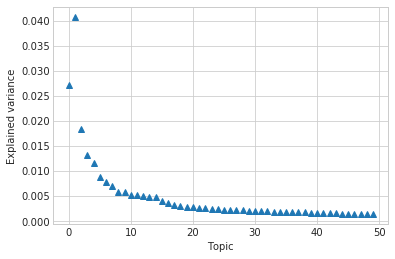

In [37]:
fig, ax = plt.subplots()
ax.plot(lsa.explained_variance_ratio_,'^')
ax.set_ylabel("Explained variance")
ax.set_xlabel("Topic");

In [54]:
terms = np.array(vectorizer.get_feature_names())
for i in range(30):
    print("topic {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))

topic 0
['hops' 'sweet' 'dark' 'bit' 'hop' 'citrus' 'ipa' 'white' 'flavor'
 'caramel' 'chocolate' 'little' 'brown' 'bottle' 'glass' 'orange' 'coffee'
 'bitterness' 'lacing' 'ale' 'just' 'bitter' 'mouthfeel' 'malts' 'really'
 'nose' 'amber' 'pine' 'pale' 'pours' 'dry' 'roasted' 'flavors' 'great'
 'fruit']
topic 1
['coffee' 'chocolate' 'dark' 'stout' 'roasted' 'black' 'brown' 'porter'
 'vanilla' 'bourbon' 'roast' 'tan' 'cocoa' 'roasty' 'milk' 'barrel'
 'molasses' 'rich' 'smoke' 'oatmeal' 'mocha' 'creamy' 'stouts' 'burnt'
 'espresso' 'oak' 'licorice' 'imperial' 'malts' 'toffee' 'pitch' 'char'
 'smooth' 'opaque' 'deep']
topic 2
['ipa' 'pine' 'grapefruit' 'citrus' 'coffee' 'tropical' 'hop' 'hops'
 'orange' 'chocolate' 'bitter' 'stout' 'mango' 'piney' 'dipa' 'pineapple'
 'black' 'bitterness' 'dank' 'hoppy' 'juicy' 'ipas' 'resin' 'roasted'
 '20164' 'double' 'tangerine' '20174' 'resinous' 'coast' 'imperial' '116'
 'citra' 'west' 'porter']
topic 3
['sour' 'bourbon' 'tart' 'saison' 'oak' 'funk' 

In [3]:
if ((not os.path.exists(nmf_mat_file)) | (not os.path.exists(nmf_model_file))):
    nmf = NMF(50)
    nmf_mat = nmf.fit_transform(count_mat)
    with open(nmf_model_file, 'wb') as file:
        pickle.dump(nmf, file)
    with open(nmf_mat_file, 'wb') as file:
        pickle.dump(nmf_mat, file)
else:
    with open(nmf_model_file, 'rb') as file:
        nmf = pickle.load(file)
    with open(nmf_mat_file, 'rb') as file:
        nmf_mat = pickle.load(file)

In [41]:
terms = np.array(vectorizer.get_feature_names())
for i in range(10):
    print("topic {}".format(i))
    print(get_topical_terms(nmf.components_,i,terms, 35))

topic 0
['amber' 'caramel' 'sweet' 'copper' 'malts' 'malty' 'clear' 'white' 'hops'
 'toffee' 'toasted' 'little' 'bit' 'lacing' 'bottle' 'decent' 'slightly'
 'bready' 'flavor' 'glass' 'sweetness' 'slight' 'pours' 'mild' 'bread'
 'bodied' 'earthy' 'pretty' 'finger' 'bitterness' 'hint' 'hop' 'moderate'
 '20133' 'average']
topic 1
['chocolate' 'black' 'dark' 'roasted' 'cocoa' 'roast' 'tan' 'roasty'
 'malts' 'licorice' 'brown' 'creamy' 'molasses' 'mocha' 'milk' 'bitter'
 'burnt' 'rich' 'bit' 'char' 'bottle' 'pitch' 'smooth' 'lacing' 'glass'
 'opaque' 'imperial' 'pours' 'ris' 'flavors' 'charred' 'little' 'nose'
 'bitterness' 'mouthfeel']
topic 2
['pine' 'grapefruit' 'citrus' 'hops' 'hop' 'bitter' 'piney' 'hoppy'
 'bitterness' 'resin' 'floral' 'resinous' 'tropical' 'big' 'fresh' 'great'
 'dry' 'lacing' '20154' 'rind' 'dank' 'glass' 'white' 'sticky' '20144'
 'resiny' 'balance' 'moderate' 'citrusy' 'bottle' '20134' 'balanced'
 'really' 'lots' 'backbone']
topic 3
['sour' 'tart' 'funk' 'sourness'

In [42]:
terms = np.array(vectorizer.get_feature_names())
for i in range(10, 20):
    print("topic {}".format(i))
    print(get_topical_terms(nmf.components_,i,terms, 35))

topic 10
['coffee' 'roasted' 'espresso' 'beans' 'black' 'roast' 'dark' 'mocha'
 'flavor' 'bitter' '20164' 'bean' 'roasty' 'cold' 'really' 'rich' 'strong'
 'grounds' 'great' '20154' 'cream' 'bitterness' 'flavors' 'creamy' 'smooth'
 'nose' 'breakfast' 'little' '20174' 'just' 'bit' 'burnt' 'lacing' 'glass'
 'ground']
topic 11
['rye' 'spicy' 'spice' 'spiciness' 'whiskey' 'bread' 'roggenbier' 'peppery'
 'hops' 'really' 'dry' '12' 'flavor' 'grain' 'character' 'earthy'
 'interesting' 'bit' 'caraway' 'barrel' 'bready' 'little' 'adds' 'nose'
 'pepper' 'grainy' 'big' '2013' 'comes' 'juniper' 'dark' 'kvass' 'creamy'
 '20143' '2012']
topic 12
['porter' 'roasted' 'porters' '159' 'dark' 'baltic' 'tan' 'roasty' 'brown'
 'roast' 'robust' 'chocolate' 'malts' 'pint' 'little' 'cocoa' 'american'
 'ruby' 'dry' 'flavor' '101' 'peanut' 'smooth' 'cola' 'bit' 'opaque'
 '20153' 'sweet' 'solid' 'coffee' 'watery' 'glass' 'hint' 'deep'
 'highlights']
topic 13
['tropical' 'mango' 'pineapple' 'fruit' '20174' 'juicy'

In [43]:
terms = np.array(vectorizer.get_feature_names())
for i in range(21, 30):
    print("topic {}".format(i))
    print(get_topical_terms(nmf.components_,i,terms, 35))

topic 21
['coriander' 'witbier' 'wit' 'peel' 'spice' 'spices' '48' 'white' 'lemon'
 'yellow' 'pepper' 'cloudy' 'clove' 'spicy' 'refreshing' 'orange' 'blanche'
 'witbiers' 'citrus' 'wits' 'hoegaarden' 'straw' 'yeast' 'wheat' 'hazy'
 'pale' 'banana' 'bottle' 'corriander' 'spiced' 'wheaty' 'moon' 'sweet'
 'bit' 'witte']
topic 22
['cherry' 'cherries' 'tart' 'kriek' 'sour' 'pink' 'sweet' 'red' 'lambic'
 'vinegar' 'flanders' 'oak' 'flavor' 'fruit' 'dark' 'ruby' 'pie' 'tartness'
 'cough' 'little' 'bit' 'reddish' 'pinkish' 'oud' 'bruin' 'juice'
 'medicinal' 'sweetness' 'brown' 'deep' 'sourness' 'acetic' 'just' 'wood'
 'cranberry']
topic 23
['brett' 'funk' 'funky' 'wild' 'barnyard' 'brettanomyces' 'dry' 'bottle'
 'hay' 'bretty' 'tart' 'white' 'pineapple' 'wine' 'farmhouse' 'earthy'
 'yeast' 'musty' 'funkiness' 'tartness' 'lemon' 'really' 'tropical' '20164'
 'fruit' '20154' 'straw' 'bit' 'hazy' 'citrus' 'nose' 'horse' 'bright'
 'character' 'yellow']
topic 24
['smoke' 'smoked' 'smokey' 'smoky' 'r

In [44]:
terms = np.array(vectorizer.get_feature_names())
for i in range(30, 40):
    print("topic {}".format(i))
    print(get_topical_terms(nmf.components_,i,terms, 35))

topic 30
['brown' 'ale' 'nutty' 'dark' 'roasted' 'caramel' 'nuts' 'nut' 'toasted'
 'tan' 'toffee' 'nuttiness' 'malts' 'sugar' 'sweet' 'malty' 'flavor'
 'english' 'little' 'chocolate' 'mild' 'bread' 'bit' 'mahogany' 'deep'
 'ales' 'reddish' 'roasty' 'hint' 'ruby' 'toasty' 'lacing' 'hazelnut' '73'
 'chestnut']
topic 31
['vanilla' 'chocolate' 'milk' 'sweet' 'cream' 'lactose' 'cinnamon' 'bean'
 'cocoa' 'creamy' '20164' '20154' 'marshmallow' 'beans' 'dessert' 'really'
 'smooth' 'sweetness' '20174' 'great' 'flavor' 'sugar' 'just' 'whiskey'
 'nose' 'brown' 'little' 'flavors' 'artificial' 'bit' 'snifter' 'rich'
 'milkshake' 'extract' 'peanut']
topic 32
['stout' 'milk' 'roasted' 'stouts' 'black' 'imperial' 'lactose' 'irish'
 'dry' 'sweet' 'tan' 'roast' 'roasty' '158' 'guinness' 'nitro' 'russian'
 'creamy' '157' 'opaque' 'little' 'flavor' 'espresso' 'pitch' 'barley' '82'
 'bit' 'jet' 'oyster' 'burnt' 'ris' 'export' '20153' 'smooth' '162']
topic 33
['dipa' 'double' 'imperial' '140' 'ipa' 'big' 'd

In [53]:
terms = np.array(vectorizer.get_feature_names())
for i in range(45, 46):
    print("topic {}".format(i))
    print(get_topical_terms(nmf.components_,i,terms, 300))

topic 45
['corn' 'bad' 'bottle' 'sweet' 'yellow' 'little' 'just' 'adjunct' 'watery'
 'macro' 'better' 'cheap' 'clear' 'bit' 'flavor' 'water' 'white' 'drink'
 'pretty' 'mouthfeel' 'really' 'glass' 'average' 'grain' 'pale' 'golden'
 'beers' 'metallic' 'quickly' 'grainy' 'tastes' 'decent' 'rice' 'actually'
 'don' 'fizzy' 'straw' 'bland' 'isn' 'poured' 'smells' 'pours' 'liquor'
 'say' '20112' 'sweetness' 'think' 'doesn' 'bud' 'way' 'skunky' 'brew'
 'gold' '20102' 'drinkability' '12' 've' 'price' 'lacing' 'aftertaste'
 'ice' 'adjuncts' 'pack' 'appearance' 'going' 'weak' 'skunk' 'grains'
 'best' 'lagers' 'slightly' 'maybe' 'high' 'faint' 'lot' 'drinking'
 'slight' '20092' 'offensive' 'cold' '20122' 'kind' 'hot' 'label'
 'carbonated' 'try' 'buy' 'does' 'worse' 'quite' 'looks' '20082' 'jan'
 '20152' 'want' 'know' 'typical' 'low' 'ok' 'euro' 'corny' 'probably' 'day'
 'mouth' 'worst' 'bubbles' 'got' 'miller' 'coors' 'oz' 'sure' 'thing'
 'fairly' '24' 'mar' 'feb' 'hint' '15' 'cooked' 'looking' 'a

The above is American adjunct lager (e.g. Budweiser).

In [5]:
lsa_dist_mat = cosine_similarity(lsa_mat, lsa_mat)

In [6]:
nmf_dist_mat = cosine_similarity(nmf_mat, nmf_mat)

In [7]:
def find_closest_beer(beer_name, dist_mat, n_beer=10):
    try:
        index = full_beer_df.loc[full_beer_df.beer == beer_name].index[0]
    except:
        print("Beer not found")
        return
    
    return full_beer_df.iloc[np.argsort(-dist_mat[index, :])[0:n_beer]]
    

In [8]:
find_closest_beer("Fresh Squeezed IPA", lsa_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
7645,6.40,4.2,Fresh Squeezed IPA,60330,Deschutes Brewery,63,"2,028",9.52%,4997,706,116,391
8711,6.00,3.99,Apostrophe IPA,118388,SoMe Brewing Company,33631,31,8.27%,108,30,116,3
7649,7.00,4.29,Duet,27604,Alpine Beer Company,3120,892,7.93%,4346,875,116,812
8184,7.17,4.03,Saint Arnold Art Car IPA,185071,Saint Arnold Brewing Company,337,87,7.94%,251,47,116,9
8683,7.60,3.87,Citrus Limbo IPA,251001,Long Trail Brewing Co,94,34,10.34%,112,31,116,5
7632,7.50,4.21,Jai Alai IPA,46363,Cigar City Brewing,17981,"2,227",9.74%,7747,1480,116,"1,034"
7948,6.80,4.15,Breakside IPA,67268,Breakside Brewery,22843,134,8.43%,460,78,116,68
7777,7.20,4.05,Truth,96304,Rhinegeist Brewery,31995,360,9.38%,949,118,116,56
7654,7.25,4.27,AleSmith IPA,3916,AleSmith Brewing Company,396,771,8.67%,4197,1336,116,520
8649,7.00,4.02,Ode IPA,178805,Castle Danger Brewery,25567,22,7.96%,117,29,116,6


In [9]:
find_closest_beer("Fresh Squeezed IPA", nmf_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
7645,6.4,4.2,Fresh Squeezed IPA,60330,Deschutes Brewery,63,"2,028",9.52%,4997,706,116,391
7948,6.8,4.15,Breakside IPA,67268,Breakside Brewery,22843,134,8.43%,460,78,116,68
7777,7.2,4.05,Truth,96304,Rhinegeist Brewery,31995,360,9.38%,949,118,116,56
8306,7.2,3.96,Finback IPA,111411,Finback Brewery,33901,50,9.6%,200,34,116,7
8471,7.5,3.77,Galaxy IPA,85472,Big Muddy Brewing,21396,26,12.47%,150,34,116,6
8711,6.0,3.99,Apostrophe IPA,118388,SoMe Brewing Company,33631,31,8.27%,108,30,116,3
8088,7.5,4.24,Melvin IPA,62740,Melvin Brewing Thai Me Up,24056,43,7.31%,300,60,116,28
7816,6.9,3.87,Wrought Iron IPA,134574,Abita Brewing Co,3,361,10.08%,782,118,116,38
7871,6.3,4.15,Fantasy Factory,95061,Karben4 Brewing,30629,164,10.63%,581,82,116,52
8649,7.0,4.02,Ode IPA,178805,Castle Danger Brewery,25567,22,7.96%,117,29,116,6


In [11]:
find_closest_beer("Drake's 1500 Pale Ale", lsa_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
39524,5.5,3.89,Drake's 1500 Pale Ale,25095,Drake's Brewing Co,3835,100,11.31%,477,136,97,28
39561,5.3,3.88,Flying Jenny Extra Pale Ale,81520,Grey Sail Brewing of Rhode Island,27710,105,9.54%,346,56,97,15
39476,6.0,3.88,30th Street Pale Ale,47244,Green Flash Brewing Co,2743,130,10.31%,732,141,97,22
39464,5.6,3.95,Osiris Pale Ale,52041,Sun King Brewing Company,20672,149,11.14%,865,226,97,80
39449,5.7,3.91,Hopalicious,30679,Ale Asylum,13837,213,11.25%,1026,240,97,32
39421,6.2,3.98,New Dogtown Pale Ale,44896,Lagunitas Brewing Company,220,340,10.3%,1893,421,97,77
39873,5.2,3.98,Arrowhead Pale Ale,70659,Marshall Brewing Company,16878,15,14.82%,101,24,97,9
39496,5.4,4.04,Day Tripper,84343,Indeed Brewing Company,29223,136,9.65%,656,110,97,46
39653,5.0,3.8,Red Racer Classic Pale Ale,42312,Central City Brewers + Distillers,10321,17,10.79%,215,120,97,9
39453,5.9,3.8,Schlafly Dry,36290,Hopped American Pale Ale,583,140,10.79%,969,323,97,22


In [12]:
find_closest_beer("Drake's 1500 Pale Ale", nmf_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
39524,5.5,3.89,Drake's 1500 Pale Ale,25095,Drake's Brewing Co,3835,100,11.31%,477,136,97,28
39476,6.0,3.88,30th Street Pale Ale,47244,Green Flash Brewing Co,2743,130,10.31%,732,141,97,22
39561,5.3,3.88,Flying Jenny Extra Pale Ale,81520,Grey Sail Brewing of Rhode Island,27710,105,9.54%,346,56,97,15
39449,5.7,3.91,Hopalicious,30679,Ale Asylum,13837,213,11.25%,1026,240,97,32
39421,6.2,3.98,New Dogtown Pale Ale,44896,Lagunitas Brewing Company,220,340,10.3%,1893,421,97,77
39496,5.4,4.04,Day Tripper,84343,Indeed Brewing Company,29223,136,9.65%,656,110,97,46
39464,5.6,3.95,Osiris Pale Ale,52041,Sun King Brewing Company,20672,149,11.14%,865,226,97,80
39699,5.3,3.66,483 Pale Ale,61118,Great River Brewery,23052,27,14.21%,178,56,97,7
40187,5.5,3.73,Pale Ale Américaine,64762,Brasserie Dunham,13905,5,10.72%,49,15,97,1
39816,5.2,4.02,Ride Again,69997,Lucette Brewing Company,24055,15,10.2%,123,27,97,7


In [14]:
find_closest_beer("Drake's Denogginizer", lsa_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
3667,9.75,3.92,Drake's Denogginizer,22273,Drake's Brewing Co,3835,203,10.46%,868,227,140,63
3643,9.90,3.93,Hop Centric Double India Pale Ale,22484,Two Brothers Brewing Company,689,99,11.96%,1042,474,140,46
3807,8.00,4.16,White Knuckle Double IPA,2749,Marin Brewing Company,812,23,10.1%,356,255,140,151
4214,9.50,4.04,Uberhoppy IPA,35398,Valley Brewing Company,5411,2,11.88%,102,88,140,25
3652,9.25,3.66,Shipwrecked Double IPA,56172,Mission Brewery,16393,158,13.39%,968,230,140,25
3783,9.75,3.89,I Beat YoU,54211,Mikkeller ApS,13307,38,12.08%,410,170,140,19
3711,7.50,3.99,Hop Whore,32757,Tyranena Brewing Company,784,43,10.78%,666,361,140,80
3748,9.50,4.03,I Hardcore You,61128,BrewDog,16315,70,12.16%,518,247,140,49
3657,9.70,3.57,Left Coast Hop Juice,38515,Left Coast Brewing Company,10046,175,14.57%,948,290,140,17
3843,9.20,4.17,Ace Of Spades,52144,Hopworks Urban Brewery,16353,28,9.35%,291,93,140,78


In [15]:
find_closest_beer("Drake's Denogginizer", nmf_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
3667,9.75,3.92,Drake's Denogginizer,22273,Drake's Brewing Co,3835,203,10.46%,868,227,140,63
3643,9.90,3.93,Hop Centric Double India Pale Ale,22484,Two Brothers Brewing Company,689,99,11.96%,1042,474,140,46
3807,8.00,4.16,White Knuckle Double IPA,2749,Marin Brewing Company,812,23,10.1%,356,255,140,151
3699,9.38,3.82,New Holland Imperial Hatter,24884,New Holland Brewing Company,335,57,10.73%,712,256,140,40
3980,8.40,3.83,Full Throttle Double IPA,47102,Sebago Brewing Company,23973,14,10.44%,182,103,140,8
4214,9.50,4.04,Uberhoppy IPA,35398,Valley Brewing Company,5411,2,11.88%,102,88,140,25
4518,9.00,3.86,Ale Mucho Hoppo,71637,Charleville Vineyard Microbrewery,10549,6,10.1%,58,24,140,5
4247,9.00,3.81,Final Frontier IIPA,74948,To Øl,24299,9,11.55%,96,26,140,6
3716,8.20,3.76,Mean Manalishi Double IPA,37518,Hoppin' Frog Brewery,14879,46,15.16%,639,368,140,29
3852,8.25,3.73,Satisfaction Jacksin,53042,Ale Asylum,13837,35,12.87%,281,98,140,17


In [87]:
find_closest_beer("Aroma Flora", lsa_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
22934,5.8,4.21,Aroma Flora,128714,Drake's Brewing Co,3835,3,9.74%,12,1,129,0
22098,6.0,3.97,Saison Francisco,110776,Cellarmaker Brewing Co,32931,0,5.79%,39,0,129,0
22923,6.3,4,'Tis The Saison,146350,Bagby Beer Company,36594,1,6.75%,12,1,129,0
22537,6.8,3.64,Un Atout Saison,130806,Beachwood BBQ & Brewing,25959,0,11.54%,19,1,129,0
23123,5.6,3.63,NFS Saison,131019,Half Moon Bay Brewing Company,2175,2,7.18%,10,0,129,0
22268,6.0,3.63,Farmer's Gold,121030,Council Brewing Company,34734,2,5.23%,28,0,129,0
22525,6.0,3.71,LA Saison,133783,Smog City Brewing,27922,1,7.55%,19,0,129,1
22362,6.3,3.23,Saison De Lilah,121454,Monkish Brewing Co,28657,4,26.01%,24,3,129,0
23047,3.8,4.14,Beatitude Amarillo Dry Hopped Tart Saison,141594,Council Brewing Company,34734,0,7.49%,10,0,129,0
23046,4.7,4.26,An Honest Day's Pay,146201,HenHouse Brewing,29164,0,10.8%,10,1,129,0


In [16]:
find_closest_beer("Aroma Flora", nmf_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
22934,5.8,4.21,Aroma Flora,128714,Drake's Brewing Co,3835,3,9.74%,12,1,129,0
22098,6.0,3.97,Saison Francisco,110776,Cellarmaker Brewing Co,32931,0,5.79%,39,0,129,0
22268,6.0,3.63,Farmer's Gold,121030,Council Brewing Company,34734,2,5.23%,28,0,129,0
23047,3.8,4.14,Beatitude Amarillo Dry Hopped Tart Saison,141594,Council Brewing Company,34734,0,7.49%,10,0,129,0
23123,5.6,3.63,NFS Saison,131019,Half Moon Bay Brewing Company,2175,2,7.18%,10,0,129,0
22525,6.0,3.71,LA Saison,133783,Smog City Brewing,27922,1,7.55%,19,0,129,1
22946,4.5,3.96,Beatitude Citra Dry Hopped Tart Saison,209123,Council Brewing Company,34734,2,11.11%,12,0,129,0
22863,6.5,4.13,Salud,222709,The Good Beer Company,36847,2,8.96%,13,0,129,1
22873,6.4,4,Sun's Out,117775,Sante Adairius Rustic Ales,28019,0,8.75%,12,0,129,0
22632,6.2,4.37,Hanging Valley,183855,Fieldwork Brewing Co,38745,1,12.59%,16,1,129,2


In [11]:
find_closest_beer("Natty Daddy (8%)", lsa_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
34058,8.0,2.54,Natty Daddy (8%),73223,Anheuser-Busch,29,60,35.83%,261,109,42,12
34050,8.1,2.48,Steel Reserve 211 (High Gravity),718,Steel Brewing Company,257,196,36.29%,1212,563,42,16
33532,5.5,1.76,Game Day Ice,57899,"City Brewing Company, LLC",782,1,51.7%,47,32,38,4
34055,6.0,2.19,King Cobra Premium Malt Liquor,66,Anheuser-Busch,29,83,36.99%,528,187,42,7
34070,8.0,2.47,Icehouse Edge,83745,Miller Brewing Co.,105,26,29.15%,133,59,42,4
34074,7.1,2.46,Labatt Max Ice,6158,Labatt Brewing Company Ltd.,478,10,28.46%,96,52,42,2
34059,5.9,2.21,Hurricane Malt Liquor,2186,Anheuser-Busch,29,36,36.2%,240,79,42,7
34078,8.2,2.24,Schlitz Bull Ice I.M.L.,3963,JOS. Schlitz Brewing Co. (Pabst),106,4,45.54%,72,53,42,8
34051,5.9,2.19,Olde English 800,3350,Miller Brewing Co.,105,191,38.81%,1041,313,42,17
33365,5.9,2.02,Natural Ice,653,Anheuser-Busch,29,287,39.6%,1404,345,38,7


In [13]:
find_closest_beer("Natty Daddy (8%)", nmf_dist_mat)

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
34058,8.00,2.54,Natty Daddy (8%),73223,Anheuser-Busch,29,60,35.83%,261,109,42,12
34074,7.10,2.46,Labatt Max Ice,6158,Labatt Brewing Company Ltd.,478,10,28.46%,96,52,42,2
34050,8.10,2.48,Steel Reserve 211 (High Gravity),718,Steel Brewing Company,257,196,36.29%,1212,563,42,16
34070,8.00,2.47,Icehouse Edge,83745,Miller Brewing Co.,105,26,29.15%,133,59,42,4
34057,8.10,2.46,Hurricane High Gravity Malt Liquor,25007,Anheuser-Busch,29,46,34.96%,341,172,42,7
34055,6.00,2.19,King Cobra Premium Malt Liquor,66,Anheuser-Busch,29,83,36.99%,528,187,42,7
34052,5.61,2.38,Colt 45 Malt Liquor,1334,Pabst Brewing Company,447,170,31.93%,876,272,42,16
34061,5.60,2.23,Magnum,809,Miller Brewing Co.,105,36,36.32%,196,63,42,2
34059,5.90,2.21,Hurricane Malt Liquor,2186,Anheuser-Busch,29,36,36.2%,240,79,42,7
33365,5.90,2.02,Natural Ice,653,Anheuser-Busch,29,287,39.6%,1404,345,38,7


### Put in model format

In [4]:
nmf_mat_norm = Normalizer(copy=False).fit_transform(nmf_mat)

In [5]:
topic_tree = KDTree(nmf_mat_norm)

In [14]:
def query_beer_topic_tree(tree, beer_name, n_beer=10):
    """
    Given a KDTree trained on topic space and a beer name,
    find the next closest n_beers in topic space
    """
    
    try:
        index = full_beer_df.loc[full_beer_df.beer == beer_name].index[0]
    except:
        print("Beer not found")
        return
    
    dist, indices = tree.query([nmf_mat_norm[index]], k = n_beer+1)
    
    return full_beer_df.iloc[indices[0], :]

In [7]:
topic_tree.query([nmf_mat_norm[full_beer_df.loc[full_beer_df.beer == "Natty Daddy (8%)"].index[0]]], k= 5)

(array([[ 0.        ,  0.04234347,  0.04268061,  0.04311794,  0.04398556]]),
 array([[34058, 34074, 34050, 34070, 34057]]))

In [15]:
query_beer_topic_tree(topic_tree, "Natty Daddy (8%)")

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
34058,8.00,2.54,Natty Daddy (8%),73223,Anheuser-Busch,29,60,35.83%,261,109,42,12
34074,7.10,2.46,Labatt Max Ice,6158,Labatt Brewing Company Ltd.,478,10,28.46%,96,52,42,2
34050,8.10,2.48,Steel Reserve 211 (High Gravity),718,Steel Brewing Company,257,196,36.29%,1212,563,42,16
34070,8.00,2.47,Icehouse Edge,83745,Miller Brewing Co.,105,26,29.15%,133,59,42,4
34057,8.10,2.46,Hurricane High Gravity Malt Liquor,25007,Anheuser-Busch,29,46,34.96%,341,172,42,7
34055,6.00,2.19,King Cobra Premium Malt Liquor,66,Anheuser-Busch,29,83,36.99%,528,187,42,7
34052,5.61,2.38,Colt 45 Malt Liquor,1334,Pabst Brewing Company,447,170,31.93%,876,272,42,16
34061,5.60,2.23,Magnum,809,Miller Brewing Co.,105,36,36.32%,196,63,42,2
34059,5.90,2.21,Hurricane Malt Liquor,2186,Anheuser-Busch,29,36,36.2%,240,79,42,7
33365,5.90,2.02,Natural Ice,653,Anheuser-Busch,29,287,39.6%,1404,345,38,7


In [17]:
query_beer_topic_tree(topic_tree, "Sculpin IPA")

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
7625,7.0,4.37,Sculpin IPA,29619,Ballast Point Brewing Company,199,"5,682",9.84%,13829,2489,116,"1,492"
7627,6.9,4.22,Stone IPA (India Pale Ale),88,Stone Brewing,147,"3,074",10.66%,11004,3031,116,462
7630,6.2,3.86,Lagunitas IPA,916,Lagunitas Brewing Company,220,"3,113",11.4%,8759,1794,116,205
7624,7.0,4.26,Two Hearted Ale,1093,"Bell's Brewery, Inc",287,"4,400",10.8%,14300,3557,116,938
7662,6.3,4.01,Sweetwater IPA,1493,SweetWater Brewing Company,273,"1,030",11.47%,3487,927,116,195
7816,6.9,3.87,Wrought Iron IPA,134574,Abita Brewing Co,3,361,10.08%,782,118,116,38
7633,7.5,4.19,Racer 5 India Pale Ale,2751,Bear Republic Brewing Co,610,"1,397",9.55%,7669,2325,116,349
7989,7.0,3.86,Saint Archer IPA,93143,Saint Archer Brewing Co,31407,132,11.4%,398,75,116,20
8649,7.0,4.02,Ode IPA,178805,Castle Danger Brewery,25567,22,7.96%,117,29,116,6
7641,6.9,4.09,"Smuttynose IPA ""Finest Kind""",16403,Smuttynose Brewing Company,141,"1,194",11.74%,5283,1839,116,341


In [18]:
with open("beer_topic_tree.p", "wb") as file:
    pickle.dump(topic_tree, file)

## Collaborative Filtering

In [24]:
full_user_df = pd.read_csv('full_user_info.csv.gz', compression='gzip')

In [25]:
full_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6109276 entries, 0 to 6109275
Data columns (total 7 columns):
beer_ba_id    int64
feel          float64
look          float64
score         float64
smell         float64
taste         float64
user_id       float64
dtypes: float64(6), int64(1)
memory usage: 326.3 MB


In [26]:
review_count = full_user_df.user_id.value_counts()

In [27]:
active_users = review_count[review_count > 10]

In [28]:
clean_full_user_df = full_user_df.loc[full_user_df.user_id.isin(active_users.index)]

In [29]:
beer_count = full_user_df.beer_ba_id.value_counts()

In [30]:
active_beers = beer_count[beer_count > 10]

In [31]:
clean_full_user_df = clean_full_user_df.loc[clean_full_user_df.beer_ba_id.isin(active_beers.index)]

In [32]:
len(clean_full_user_df.user_id.unique())

42478

In [33]:
len(clean_full_user_df.beer_ba_id.unique())

37094

#### Create user-rating matrix

In [34]:
def create_user_rating_mat(df_user_rat):
    """
    Takes dataframe of users, ratings, and beers
    
    returns arrays of user ids, beer ids, and a sparse user-rating matrix
    """
    df_user_rating_group = pd.pivot_table(df_user_rat, values=["score"],
        index=["user_id", "beer_ba_id"],
        aggfunc=np.mean)
    
    df_user_rating_group.score -= df_user_rating_group.score.mean()
    
    user_rating_mat = df_user_rating_group.unstack(fill_value=0)
    user_ids = np.array(user_rating_mat.index)
    beer_ids = np.array(user_rating_mat.columns.get_level_values('beer_ba_id'))
    
    user_rating_mat = coo_matrix(user_rating_mat.values)
    
    return user_ids, beer_ids, user_rating_mat
    

In [35]:
user_ids, beer_ids, user_rating_mat = create_user_rating_mat(clean_full_user_df)

In [36]:
user_rating_mat

<42478x37094 sparse matrix of type '<class 'numpy.float64'>'
	with 5946506 stored elements in COOrdinate format>

In [37]:
beer_ids

array([     5,      6,      9, ..., 291019, 291158, 292433])

In [38]:
user_ids

array([  1.00000000e+00,   2.00000000e+00,   3.00000000e+00, ...,
         1.20739200e+06,   1.20755700e+06,   1.20827100e+06])

In [39]:
U, Sigma, VT = randomized_svd(user_rating_mat, 
                              n_components=50,
                              n_iter=5,
                              random_state=None)

In [40]:
# For fifty components
Sigma/Sigma.sum()

array([ 0.09962785,  0.06178635,  0.03730787,  0.03387522,  0.03109974,
        0.02641702,  0.0245082 ,  0.02357529,  0.0216676 ,  0.02112342,
        0.02069106,  0.02025783,  0.01979717,  0.01970747,  0.0189173 ,
        0.01861463,  0.0182939 ,  0.01802797,  0.01778545,  0.01748843,
        0.01695544,  0.01682274,  0.01653118,  0.01638108,  0.01621397,
        0.01596312,  0.0157343 ,  0.01562291,  0.01523483,  0.01498408,
        0.01490167,  0.01468984,  0.01450191,  0.01440195,  0.0141579 ,
        0.01412151,  0.01383171,  0.01371939,  0.01357275,  0.01325493,
        0.0131806 ,  0.01302413,  0.01291008,  0.0128804 ,  0.01279886,
        0.01273829,  0.01262873,  0.01261338,  0.01253808,  0.01252047])

In [41]:
np.cumsum(Sigma)/Sigma.sum()

array([ 0.09962785,  0.16141419,  0.19872206,  0.23259728,  0.26369702,
        0.29011404,  0.31462224,  0.33819753,  0.35986513,  0.38098855,
        0.40167961,  0.42193744,  0.4417346 ,  0.46144207,  0.48035937,
        0.498974  ,  0.5172679 ,  0.53529586,  0.55308132,  0.57056974,
        0.58752518,  0.60434792,  0.6208791 ,  0.63726019,  0.65347415,
        0.66943727,  0.68517157,  0.70079448,  0.71602931,  0.73101339,
        0.74591506,  0.7606049 ,  0.77510681,  0.78950877,  0.80366667,
        0.81778818,  0.83161989,  0.84533928,  0.85891204,  0.87216697,
        0.88534757,  0.8983717 ,  0.91128178,  0.92416218,  0.93696104,
        0.94969934,  0.96232806,  0.97494144,  0.98747953,  1.        ])

### Predictions for website user

In [43]:
user_ids[4]

16.0

In [56]:
user_0_pred = np.dot(U[4, :], np.dot(np.diag(Sigma), VT))

In [57]:
user_0_pred.shape

(37094,)

In [58]:
np.argsort(user_0_pred)[:4]

array([234,  53,  54,  51])

In [59]:
np.argsort(-user_0_pred)[:4]

array([ 227, 6628, 7297,  630])

In [60]:
top_10 = beer_ids[np.argsort(-user_0_pred)[:10]]

In [61]:
full_beer_df.loc[full_beer_df.beer_ba_id.isin(top_10)]

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
3525,18.0,3.96,120 Minute IPA,9086,Dogfish Head Craft Brewery,64,"3,895",16.41%,8165,2318,140,"1,437"
6330,12.2,4.48,The Abyss,34420,Deschutes Brewery,63,"3,896",9.38%,7096,1962,157,"2,950"
7625,7.0,4.37,Sculpin IPA,29619,Ballast Point Brewing Company,199,"5,682",9.84%,13829,2489,116,"1,492"
23163,9.0,4.31,La Fin Du Monde,34,Unibroue,22,"2,295",11.37%,10052,2975,58,649
30903,5.4,4.4,Weihenstephaner Hefeweissbier,731,Bayerische Staatsbrauerei Weihenstephan,252,"1,960",10%,8317,2530,89,881
33350,4.6,2.82,Miller High Life,580,Miller Brewing Co.,105,901,28.01%,3746,1147,38,46
33352,5.0,2.71,Coors,1276,Coors Brewing Company,306,679,27.68%,2914,723,38,30
33364,4.5,2.5,Sol,2803,"Cervecería Cuauhtémoc Moctezuma, S.A. de C.V.",57,308,26.8%,1408,399,38,13
34685,3.5,2.42,Amstel Light,436,Amstel Brouwerij B. V.,163,250,27.27%,1541,497,39,9
39398,6.2,4.53,Zombie Dust,64228,3 Floyds Brewing Co,26,"3,315",8.61%,10058,1566,97,"4,764"


In [62]:
user_0_pred[np.argsort(-user_0_pred)[:10]]

array([ 0.07428179,  0.05406768,  0.0439881 ,  0.04317402,  0.03901147,
        0.03312931,  0.02909665,  0.02800146,  0.02742434,  0.02737991])

In [63]:
user_rating_mat.todense()[0, np.argsort(-user_0_pred)[:10]]

matrix([[ 0.       ,  0.       ,  0.2277723,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ]])

In [42]:
beer_mat = np.dot(np.diag(Sigma), VT)

In [43]:
beer_space_norm = Normalizer(copy=False).fit_transform(beer_mat.T)

In [44]:
beer_space = pd.DataFrame(beer_space_norm, index=beer_ids)

In [45]:
beer_space.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
5,-0.695175,-0.162350,-0.021739,-0.486752,0.016132,-0.226801,-0.041909,-0.243689,-0.002210,0.070713,...,-0.166832,-0.004006,0.011531,0.104819,0.003176,0.002330,-0.028865,0.056013,0.027585,0.022119
6,-0.675101,-0.137609,-0.123202,-0.496773,0.092431,-0.309849,-0.001939,-0.162272,0.039320,-0.016222,...,-0.100599,-0.029238,-0.016224,0.081172,0.033810,0.017346,-0.053037,0.048064,-0.038764,0.038395
9,-0.533549,-0.188402,0.112844,-0.442155,-0.200157,0.094500,0.058370,-0.191977,-0.103906,-0.019946,...,-0.167452,-0.088132,0.018199,0.146959,0.015960,-0.090329,0.048699,0.008697,0.047300,0.005091
10,-0.338988,-0.051993,-0.393104,-0.380899,0.182068,-0.460395,0.121827,-0.168402,0.051468,-0.210734,...,0.037349,0.027214,-0.008343,-0.038961,0.003784,-0.066922,0.005175,-0.014737,0.008268,-0.077954
14,-0.347311,-0.029587,-0.089083,-0.591497,0.047379,0.052755,0.173306,-0.082847,-0.120284,-0.129179,...,0.055971,-0.018825,0.070618,-0.068935,0.060296,-0.096916,0.001047,-0.051111,-0.034185,0.003887


In [68]:
beer_space.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37094 entries, 5 to 292433
Data columns (total 50 columns):
0     37094 non-null float64
1     37094 non-null float64
2     37094 non-null float64
3     37094 non-null float64
4     37094 non-null float64
5     37094 non-null float64
6     37094 non-null float64
7     37094 non-null float64
8     37094 non-null float64
9     37094 non-null float64
10    37094 non-null float64
11    37094 non-null float64
12    37094 non-null float64
13    37094 non-null float64
14    37094 non-null float64
15    37094 non-null float64
16    37094 non-null float64
17    37094 non-null float64
18    37094 non-null float64
19    37094 non-null float64
20    37094 non-null float64
21    37094 non-null float64
22    37094 non-null float64
23    37094 non-null float64
24    37094 non-null float64
25    37094 non-null float64
26    37094 non-null float64
27    37094 non-null float64
28    37094 non-null float64
29    37094 non-null float64
30    37094 non-null

In [47]:
with open('beer_space_mat.p', 'wb') as file:
    pickle.dump(beer_space, file)

In [48]:
with open('beer_id_index.p', 'wb') as file:
    pickle.dump(beer_ids, file)

### Cluster beer space

In [49]:
with open('beer_space_mat.p', 'rb') as file:
    beer_space = pickle.load(file)

In [51]:
with open('beer_id_index.p', 'rb') as file:
    beer_ids = pickle.load(file)

In [52]:
beer_space.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
5,-0.695175,-0.162350,-0.021739,-0.486752,0.016132,-0.226801,-0.041909,-0.243689,-0.002210,0.070713,...,-0.166832,-0.004006,0.011531,0.104819,0.003176,0.002330,-0.028865,0.056013,0.027585,0.022119
6,-0.675101,-0.137609,-0.123202,-0.496773,0.092431,-0.309849,-0.001939,-0.162272,0.039320,-0.016222,...,-0.100599,-0.029238,-0.016224,0.081172,0.033810,0.017346,-0.053037,0.048064,-0.038764,0.038395
9,-0.533549,-0.188402,0.112844,-0.442155,-0.200157,0.094500,0.058370,-0.191977,-0.103906,-0.019946,...,-0.167452,-0.088132,0.018199,0.146959,0.015960,-0.090329,0.048699,0.008697,0.047300,0.005091
10,-0.338988,-0.051993,-0.393104,-0.380899,0.182068,-0.460395,0.121827,-0.168402,0.051468,-0.210734,...,0.037349,0.027214,-0.008343,-0.038961,0.003784,-0.066922,0.005175,-0.014737,0.008268,-0.077954
14,-0.347311,-0.029587,-0.089083,-0.591497,0.047379,0.052755,0.173306,-0.082847,-0.120284,-0.129179,...,0.055971,-0.018825,0.070618,-0.068935,0.060296,-0.096916,0.001047,-0.051111,-0.034185,0.003887


In [53]:
beer_ids

array([     5,      6,      9, ..., 291019, 291158, 292433])

In [21]:
rating_tree = KDTree(beer_space)

In [104]:
def query_beer_rating_tree(tree, beer_name, n_beer=10):
    """
    Takes KDTree trained on user space and beer name
    
    returns list of 10 next beers closest in user rating space
    """
    
    try:
        beer_id = full_beer_df.loc[full_beer_df.beer == beer_name].beer_ba_id.values
        beer_entry = beer_space.loc[beer_id[0], :]
    except:
        print("Beer not found")
        return
    dist, indices = tree.query([beer_entry], k=n_beer+1)
    nearest_ids = beer_ids[indices[0]]
    mask = full_beer_df.beer_ba_id.isin(nearest_ids)
    
    return full_beer_df.loc[mask]
    

In [105]:
full_beer_df.loc[full_beer_df.beer == "Sculpin IPA"].beer_ba_id.values

array([29619])

In [106]:
query_beer_rating_tree(rating_tree, "Sculpin IPA")

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
1636,8.30,4.23,Wookey Jack,79286,Firestone Walker Brewing Co,2210,983,8.75%,4610,702,175,342
3523,9.40,4.4,Stone Enjoy By IPA,84596,Stone Brewing,147,"3,126",9.09%,10750,1492,140,817
3524,7.85,4.31,Lagunitas Sucks (Brown Shugga Substitute Ale),74986,Lagunitas Brewing Company,220,"2,678",9.74%,10249,1613,140,653
3526,8.10,4.19,West Coast IPA,22505,Green Flash Brewing Co,2743,"1,983",10.5%,7878,1884,140,455
3527,8.00,4.18,Hop Stoopid,35738,Lagunitas Brewing Company,220,"1,691",9.81%,7662,2152,140,327
3528,8.70,4.27,DirtWolf,99873,Victory Brewing Company,345,"2,017",9.13%,6605,855,140,337
3533,10.80,4.3,Stone RuinTen Triple IPA,82250,Stone Brewing,147,"1,098",9.3%,5822,903,140,363
3534,10.20,4.2,Maharaja,22352,Avery Brewing Company,30,868,10.24%,5628,1868,140,395
3542,9.50,4.14,Palate Wrecker,45175,Green Flash Brewing Co,2743,713,10.39%,4137,762,140,217
7636,7.00,4.23,Union Jack India Pale Ale,38180,Firestone Walker Brewing Co,2210,"1,702",9.46%,6625,1356,116,516


In [107]:
query_beer_rating_tree(rating_tree, "Natty Daddy (8%)")

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants
12924,5.2,3.05,Blue Moon Summer Honey Wheat,70089,Coors Brewing Company,306,370,20.66%,1118,153,93,26
12942,5.8,2.75,Shock Top Wheat IPA,77972,Anheuser,29,45,22.91%,484,108,93,6
12947,5.4,2.77,Blue Moon Spring Blonde Wheat Ale,65085,Coors Brewing Company,306,43,21.66%,404,95,93,7
17522,5.2,3.16,Shock Top Pumpkin Wheat,72412,Anheuser,29,304,20.89%,1206,231,72,33
23907,5.4,2.99,Kirkland Signature Belgian White,66603,Kirkland Signature Costco Wholesale Corporation,21516,3,18.73%,61,27,48,0
33377,5.9,2.01,Keystone Ice,2947,Coors Brewing Company,306,140,35.82%,721,157,38,3
33774,6.0,2.83,Budweiser Black Crown,88582,Anheuser-Busch,29,300,24.73%,1110,208,147,17
34053,8.0,2.34,Bud Light Lime-A-Rita,82948,Anheuser-Busch,29,239,35.04%,713,78,42,8
34056,8.0,2.4,Bud Light Lime Straw-Ber-Rita,91814,Anheuser-Busch,29,163,36.25%,453,66,42,7
34682,4.1,1.99,Keystone Light,1341,Coors Brewing Company,306,463,36.68%,1978,485,39,21


In [108]:
with open('beer_rating_tree.p', 'wb') as file:
    pickle.dump(rating_tree, file)